In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [5]:
N, C, H, W = 1, 4, 3, 3
FN, FC, FH, FW = 4, 3, 3, 3
PH, PW = 0, 0
SH, SW = 1, 1

sample_input = np.random.randn(N * C * H * W).reshape(N, C, H, W)
sample_filter = np.ones(FN * FC * FH * FW).reshape(FN, FC, FH, FW)
sample_pad = np.array([PH, PW])
sample_stride = np.array([SH, SW])
sample_y = np.random.randint(30, 31, N*FN*16).reshape(N, FN, 4, 4)

### 【問題1】2次元畳み込み層の作成

In [17]:
class Conv2d:
    def __init__(self, lr, F, P, S, sigma=0.01):
        self.lr = lr
        
        # filterを4次元(FN, FC, FH, FW)にする
        if F.ndim == 1:
            F = F[np.newaxis, np.newaxis, np.newaxis, :]
        elif F.ndim == 2:
            F = F[np.newaxis, np.newaxis, :, :]
        elif F.ndim == 3:
            F = F[np.newaxis, :, :, :]
            
        self.F = F
        self.P = P
        self.S = S
        
        # input value
        self.N_in = None # sample数
        self.C_in = None # channel数
        self.H_in = None # kernel height
        self.W_in = None # kernel width
        
        # filter
        self.FN = self.F.shape[0] # filter数
        self.FC = self.F.shape[1] # kernel数
        self.FH = self.F.shape[2] # kernel height
        self.FW = self.F.shape[3] # kernel width
        
        # bias
        self.sigma = sigma # 標準偏差
        self.B = self.sigma * np.random.randn(self.FC).reshape(self.FC, 1, 1)
        
        # padding
        self.PH = self.P[0] # height
        self.PW = self.P[1] # width
        
        # stride
        self.SH = self.S[0] # height
        self.SW = self.S[1] #width
        
        # output value
        self.N_out = None # sample数
        self.C_out = None # channel数
        self.H_out = None # height
        self.W_out = None # width
        
        # differential
        self.dA = None # 後の層からの勾配
        self.dB = None # bias
        self.dF = None # filter
        self.dZ = None # 前の層に流す勾配
        
    def forward(self, Z):
        # channel情報が存在しない場合、入力値を4次元(N, C, H, W)にする
        if Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
            
        self.Z = Z.copy()
        
        # input value
        self.N_in = Z.shape[0] # sample数
        self.C_in = Z.shape[1] # channel数
        self.H_in = Z.shape[2] # kernel height
        self.W_in = Z.shape[3] # kernel width
        
        # output value
        self.N_out = self.N_in # sample数(input valueと等しい)
        self.C_out = self.FN # channel数(filter枚数と等しい)
        
        # outputを0で初期化(shape: N_in, FN, OH, OW)
        N_out = self.calc_OutputSize()
        
        # Convolution演算用の配列を生成(channel, H, W)
        conv = np.zeros((self.FC, self.H_out, self.W_out))
        
        # 畳み込まれるinput dataを格納する配列(N_out, FN, FC, H_out*W_out, FH*FW)
        self.conv_z = np.zeros((self.N_out, self.FN, self.FC, self.H_out*self.W_out, self.FH*self.FW))
        
        # convolutionを行う
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    count = 0
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            self.conv_z[n_out][fn][fc][count] = Z[n_out][fc][self.SH*h : self.FH+self.SH*h, self.SW*w : self.FW+self.SW*w].flatten()
                            count += 1
                    # filteringした入力値とfilterのアダマール積を取り、biasを加える
                    adam = self.conv_z[n_out][fn][fc] * self.F[fn][fc].flatten()
                    conv[fc] = np.sum(adam, axis=1).reshape(self.H_out, self.W_out)
                # convをchannel方向に足し合わせて、置換
                conv += self.B
                conv_sum = np.sum(conv, axis=0)
                
                N_out[n_out][fn] = conv_sum
                
        return N_out
    
    def backward(self, dA):
        self.dA = dA.copy()
        
        # bias
        self.dB = np.mean(dA, axis=(-2,-1))
        
        # weight
        self.dF = np.zeros((self.FN, self.FC, self.FH, self.FW))
        conv = np.zeros((self.H_out * self.W_out, self.FH * self.FW))
        
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for i in range(self.H_out*self.W_out):
                        conv[i] = dA[n_out][fn].flatten()[i] * self.conv_z[n_out][fn][fc][i]
                    self.dF[fn][fc] = np.sum(conv, axis=0).reshape(self.FH, self.FW)
                    
        # 前の層へのgradient
        self.dZ = np.zeros((self.N_in, self.C_in, self.H_in, self.W_in))
        
        # 各kernelのgradient
        dZ_conv = np.zeros((self.H_out*self.W_out, self.H_in, self.W_in))
        
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            conv[h+w][self.SH*h:self.SH*h+self.FH, self.SW*w:self.SW*w+self.FW] = dA[n_out][fn].flatten()[i]*self.F[fn][fc]
                    dZ_conv[n_out][fn+fc] = np.sum(conv, axis=0) # depth方向にsum
                    
        # channel毎に合計する
        for n in range(self.N_in):
            for c in range(self.C_in):
                for i in range(self.FN * self.FC):
                    if i % self.C_in == c:
                        self.dZ[n][c] += dZ_conv[n][i]
                        
        return self.dZ
    
    def calc_OutputSize(self):
        # output sizeを計算する
        self.H_out = int((self.H_in + 2*self.PH - self.FH) / self.SH) + 1 # height
        self.W_out = int((self.W_in + 2*self.PW - self.FW) / self.SW) + 1 # width
        
        # 出力値を初期化する
        N_out = np.zeros((self.N_out, self.C_out, self.H_out, self.W_out)) # initialize
        
        return N_out

In [25]:
class Conv2d:
    
    def __init__(self, lr, F, P, S, sigma=0.01):
        
        self.lr = lr
        
        # filterを4次元（FN, FC, FH, FW）にする
        if F.ndim == 1:
            F = F[np.newaxis, np.newaxis, np.newaxis, :]
        elif F.ndim == 2:
            F = F[np.newaxis, np.newaxis, :, :]
        elif F.ndim == 3:
            F = F[np.newaxis, :, :, :]
        
        self.F = F
        self.P = P
        self.S = S
        
        # input value
        self.N_in = None # sample数
        self.C_in = None # channel数
        self.H_in = None # height
        self.W_in = None # width   
        
        # filter
        self.FN = self.F.shape[0] # filter数
        self.FC = self.F.shape[1] # kernel数
        self.FH = self.F.shape[2] # kernel height
        self.FW = self.F.shape[3] # kernel width
        
        # bias
        self.sigma = sigma # 標準偏差
        self.B = self.sigma * np.random.randn(self.FC).reshape(self.FC, 1, 1)
        
        # padding
        self.PH = self.P[0] # height
        self.PW = self.P[1] # width
                
        # stride
        self.SH = self.S[0] # height
        self.SW = self.S[1] # width
        
        # output value
        self.N_out = None # sample数
        self.C_out = None # channel数
        self.H_out = None # height
        self.W_out = None # width
        
        # differential
        self.dA = None # 後の層からのgradient
        self.dB = None # bias
        self.dF = None # filter
        self.dZ = None # 前の層に流すgradient
    
    
    def forward(self, Z):
        # channel情報が存在しない場合、入力値を4次元（N, C, H, W）にする
        if Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        self.Z = Z.copy()
        
        # input
        self.N_in = Z.shape[0] # sample数
        self.C_in = Z.shape[1] # channel数
        self.H_in = Z.shape[2] # height
        self.W_in = Z.shape[3] # width
        
        # output
        self.N_out = self.N_in # sample数（inputの数に等しい）
        self.C_out = self.FN # channel数（filterの枚に等しい）
        
        # 出力をゼロで初期化（shape：N_in, FN, OH, OW）
        N_out = self.calc_OutputSize()
        
        # convolution演算用の配列を生成する（channel, H, W）
        conv = np.zeros((self.FC, self.H_out,  self.W_out))
        
        # 畳み込まれる入力値を格納する配列（N_out, FN, FC, H_out*W_out, FH * FW）
        self.conv_z = np.zeros((self.N_out, self.FN, self.FC, self.H_out*self.W_out, self.FH*self.FW))
        
        # convolution演算を行う
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    count = 0
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            self.conv_z[n_out][fn][fc][count] = Z[n_out][fc][self.SH*h : self.FH + self.SH*h, self.SW*w : self.FW + self.SW*w].flatten()
                            count += 1
                    # フィルタリングした入力値とフィルタのアダマール積を取り、バイアスを加算する
                    adam = self.conv_z[n_out][fn][fc] * self.F[fn][fc].flatten()
                    conv[fc] = np.sum(adam, axis=1).reshape(self.H_out, self.W_out)
                # convをチャネル方向にsumして、置換する
                conv += self.B
                conv_sum = np.sum(conv, axis=0)

                N_out[n_out][fn] = conv_sum

        return N_out
    
    
    def backward(self, dA):
        self.dA = dA.copy()
        
        # bias
        self.dB = np.mean(dA, axis=(-2,-1))
        
        # weight
        self.dF = np.zeros((self.FN, self.FC, self.FH, self.FW))
        conv = np.zeros((self.H_out * self.W_out, self.FH * self.FW))
                    
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for i in range(self.H_out*self.W_out):                        
                        conv[i] = dA[n_out][fn].flatten()[i] * self.conv_z[n_out][fn][fc][i]
                    self.dF[fn][fc] = np.sum(conv, axis=0).reshape(self.FH, self.FW)
                    

        # 前の層へのgradient
        self.dZ = np.zeros((self.N_in , self.C_in , self.H_in , self.W_in))
        
        # 各kernelのgradient
        dZ_conv = np.zeros((self.N_in, self.FN * self.FC, self.H_in, self.W_in))
        
        # dAとfilterのアダマール積をstride毎に格納する配列
        conv = np.zeros((self.H_out*self.W_out, self.H_in, self.W_in))
        
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            conv[h+w][self.SH*h : self.SH*h + self.FH, self.SW * w: self.SW*w + self.FW] = dA[n_out][fn].flatten()[i] * self.F[fn][fc]
                    dZ_conv[n_out][fn+fc] = np.sum(conv, axis=0) # 深さ方向にsum
        
        # 最後にchannel毎に合計する
        for n in range(self.N_in):
            for c in range(self.C_in):
                for i in range(self.FN * self.FC):
                    if i % self.C_in == c:
                        self.dZ[n][c] += dZ_conv[n][i]
                                
        return self.dZ
    
    
    def calc_OutputSize(self, ):
        # outputを計算する
        self.H_out = int((self.H_in + 2*self.PH - self.FH) / self.SH) + 1 # 高さ
        self.W_out = int((self.W_in + 2*self.PW - self.FW) / self.SW) + 1 # 幅

        # outputを初期化する
        N_out = np.zeros((self.N_out, self.C_out , self.H_out, self.W_out)) # 初期化
        
        return N_out

### **検証**

In [26]:
clf = Conv2d(lr=1e-2, F=sample_filter, P=sample_pad, S=sample_stride)
N_out = clf.forward(sample_input)
# N_out.shape
N_out

array([[[[-3.64064956]],

        [[-3.64064956]],

        [[-3.64064956]],

        [[-3.64064956]]]])

In [27]:
# loss
dA = N_out - sample_y
dA.shape

(1, 4, 4, 4)

In [28]:
clf.backward(dA).shape

(1, 4, 3, 3)

### 【問題2】2次元畳み込み後の出力サイズ

In [29]:
def calc_OutputSize(input_data, P, F, S):
    
    # 入力値を4次元（N, C, H, W）にする
    if input_data.ndim == 1:
        input_data = input_data[np.newaxis, np.newaxis, np.newaxis, :]
    elif input_data.ndim == 2:
        input_data = input_data[np.newaxis, np.newaxis, :, :]
    elif input_data.ndim == 3:
        input_data = input_data[np.newaxis, :, :, :]
    
    # filterを4次元（FN, FC, FH, FW）にする
    if F.ndim == 1:
        F = F[np.newaxis, np.newaxis, np.newaxis, :]
    elif F.ndim == 2:
        F = F[np.newaxis, np.newaxis, :, :]
    elif F.ndim == 3:
        F = F[np.newaxis, :, :, :]
    
    
    # 指標
    #print("input_data.shape : {}".format(input_data.shape))
    N_in = input_data.shape[0] # sample数
    C_in = input_data.shape[1] # channel数
    H_in = input_data.shape[2] # height
    W_in = input_data.shape[3] # width
    
    FN = F.shape[0] # filter数
    FC = F.shape[1] # channel数
    FH = F.shape[2] # height
    FW = F.shape[3] # width
    
    PH = P[0] # height
    PW = P[1] # width
    
    SH = S[0] # height
    SW = S[1] # width
    
    # 出力サイズを計算する
    H_out = int((H_in + 2*PH - FH) / SH) + 1 # 高さ
    W_out = int((W_in + 2*PW - FW) / SW) + 1 # 幅
    
    # 出力値を初期化する
    N_out = np.zeros((N_in, FN , H_out, W_out)) # 初期化
    
    return N_out

In [30]:
N_out = calc_OutputSize(sample_input, sample_pad, sample_filter, sample_stride)
N_out.shape

(1, 4, 1, 1)

### 【問題3】最大プーリング層の作成

In [31]:
class MaxPool2D:
    
    def __init__(self, stride=1, pad=0):
        
        self.stride = stride
        self.pad = pad
        
        self.pool = None
        self.pool_row = None
        self.pool_col = None
        
        self.Z = 0
    
    def forward(self, Z):
        # 入力値を4次元（N, C, H, W）にする
        if Z.ndim == 1:
            Z = Z[np.newaxis, np.newaxis, np.newaxis, :]
        elif Z.ndim == 2:
            Z = Z[np.newaxis, np.newaxis, :, :]
        elif Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        # input値（sample、channel、height、width）
        self.N, self.C, self.H, self.W = Z.shape
        
        # stride（height、width）
        SH, SW = self.stride[0], self.stride[1]
        
        # stride数
        self.NH = int(self.H / SH) # height方向に動く回数
        self.NW = int(self.W  / SW) # width方向に動く回数
        
        # pooling層を初期化
        self.pool = np.zeros((self.N, self.C, self.NH, self.NW))
        self.pool_row = np.zeros((self.N, self.C, self.NH * self.NW))
        self.pool_col = np.zeros((self.N, self.C, self.NH * self.NW))
        
        
        # pooling
        for n in range(self.N):
            for c in range(self.C):
                count = 0
                for mh in range(self.NH):
                    for mw in range(self.NW):
                        extract = Z[n][c][SH*mh : SH*(mh+1), SW*mw: SW*(mw+1)] # stride
                        self.pool[n][c][mh][mw] = np.amax(extract) # strideした範囲内で最大値をを見つける
                        index_max = np.unravel_index(np.argmax(extract), extract.shape) # 最大値のindexを取得
                        self.pool_row[n][c][count] = index_max[0] + SH*mh
                        self.pool_col[n][c][count] = index_max[1] + SW*mw
                        count += 1
        
        return self.pool_row, self.pool_col
    
    
    def backward(self, dA):
        
        dZ = np.zeros((self.N, self.C, self.H, self.W))
        
        for n in range(self.N):
            for c in range(self.C):
                for i in range(self.NH * self.NW):
                    h = int(self.pool_row[n][c][i]) # gradientを流す要素の行番号
                    w = int(self.pool_col[n][c][i]) # gradientを流す要素の列番号
                    dZ[n][c][h:h+1,w:w+1] = dA[n][c][h:h+1,w:w+1]
        
        return dZ

### 検証

In [32]:
N = 1
C = 1
H = 4
W = 4

sample = np.arange(N*C*H*W).reshape(N, C, H, W)
stride = np.array([2, 2])

H = sample.shape[0]
W = sample.shape[1]
H_S = stride[0]
W_S = stride[1]

sample, stride

(array([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]]), array([2, 2]))

In [33]:
clf = MaxPool2D(stride=stride)
pool = clf.forward(sample)
clf.backward(sample)

array([[[[ 0.,  0.,  0.,  0.],
         [ 0.,  5.,  0.,  7.],
         [ 0.,  0.,  0.,  0.],
         [ 0., 13.,  0., 15.]]]])

### 【問題4】平滑化

In [34]:
class Flatten:
    
    def __init__(self, ):
        
        self.N = None
        self.C = None
        self.H = None
        self.W = None
        
        self.flat_Z = None
    
    def forward(self, Z):
        # 入力値の形状をインスタンス変数に格納
        self.N = Z.shape[0] # sample数
        self.C = Z.shape[1] # channel数
        self.H = Z.shape[2] # height
        self.W = Z.shape[3] # width
        
        
        # 平滑化する値をゼロで初期化しておく
        self.flat_Z = np.zeros(self.N*self.C*self.H*self.W).reshape(self.N, self.C, self.H*self.W)
        
        for n in range(self.N):
            for c in range(self.C):
                self.flat_Z[n][c] = Z[n][c].flatten()
        
        return self.flat_Z
    
    
    def backward(self, dA):
        dA  = dA.flatten().reshape(self.N, self.C, self.H, self.W)
        
        return dA

### 検証

In [35]:
flatten = Flatten()
flat_forward = flatten.forward(sample)
flat_backward = flatten.backward(sample)

In [36]:
flat_forward.shape, flat_backward.shape

((1, 1, 16), (1, 1, 4, 4))

### 【問題5】学習・推定

In [40]:
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm_notebook as tqdm

In [41]:
class Scratch2dCNNClassifier:
    
    def __init__(self, activation="Tanh", batch=30, filter_info=(1,4,3,3), initializer="He", n_epochs=30, lr=1e-2, n_nodes1=400, n_nodes2=200, optimizer="AdaGrad", padding=0,  sigma=0.01, stride=1, verbose=False):
        
        # パラメータ
        self.activation = activation
        self.batch = batch
        self.initializer = initializer
        self.lr = lr
        self.n_epochs = n_epochs
        self.n_features = 64
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = 10
        self.optimizer = optimizer
        self.sigma = sigma
        self.verbose = verbose
        
        self.F = filter_info # フィルタの特徴量は１次元のNumpy配列（FN, FC, FH, FW）で与える。
        self.P = padding
        self.S = stride
        
        # parameter initializer
        if self.initializer == "Simple":
            initializer = SimpleInitializer(self.sigma)
        elif self.initializer == "Xavier":
            initializer = XavierInitializer()
        elif self.initializer == "He":
            initializer = HeInitializer()
        
        # 最適化手法
        if self.optimizer == "SGD":
            optimizer = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer = AdaGrad(self.lr)
        
        # layer（インスタンス生成）
        self.Conv = Conv2d(self.lr, self.F, self.P, self.S, self.sigma) # convolution層
        self.Pool = MaxPool2D(self.S, self.P) # pooling層
        self.Flat = Flatten() # flatten
        self.FC = FC(self.n_features, self.n_output, initializer, optimizer) # FC層
            
        # activate function
        self.activation2 = Softmax()
        if self.activation == "Sigmoid":
            self.activation1 = Sigmoid()
        elif self.activation == "Tanh":
            self.activation1 = Tanh()
        elif self.activation == "ReLU":
            self.activation1 = ReLU()
        
        
        # loss
        self.train_loss = []
        self.val_loss = []
        
        # prediction
        self.y_pred = None
        
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):

        # 特徴量にチャンネルの次元がない場合、チャンネルの軸を追加する
        if X_train.ndim == 3:
            X_train = X_train[:, np.newaxis, :, :]

        # 入力データのチャンネル数とフィルタのチャンネル数の一致を確認する
        if X_train.shape[1] != self.F[1]:
            print("Channels of X_train and filter should be same.")

        # One-Hot Encoding
        enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
        y_train = enc.fit_transform(y_train[:, np.newaxis]) # 学習用データ
        
        # 検証用データが存在する場合は、同様に前処理する
        if (X_val is not None) and  (y_val is not None):
            y_val = enc.fit_transform(y_val[:, np.newaxis])            
            if X_val.ndim == 3:
                X_val = X_val[:, np.newaxis, :, :]
            if X_val.shape[1] != self.F[1]:
                print("Channels of X_val and filter should be same.")
            
            
        # 選択した最適化手法による学習を繰り返す
        for i in tqdm(range(self.n_epochs)):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size = self.batch, seed = 0)
            for mini_X_train, mini_y_train in tqdm(get_mini_batch):
                
                # forward propagation
                A1 = self.Conv.forward(mini_X_train) # Conv (30, 1, 26, 26)
                Z1 = self.activation1.forward(A1) # ReLU
                Z2 = self.Pool.forward(Z1) # Pool
                Z3 = self.Flat.forward(Z2) # Flatten
                A2 = self.FC.forward(Z3) # Affine
                Z4 = self.activation2.forward(A2) # SoftMax
        
                # backward propagation
                dA2, train_loss = self.activation2.backward(Z4, mini_y_train)
                dZ3 = self.FC.backward(dA2)
                dZ2 = self.Flat.backward(dZ3)
                dZ1 = self.Pool.backward(dZ2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Conv.backward(dA1)
                
                self.train_loss.append(train_loss)
                
                if self.verbose == True:
                    print("train_loss : {}".format(train_loss))
                
                # 検証用データを用いる場合、損失を計算する
                if (X_val is not None) and (y_val is not None):
                    A1_val = self.Conv.forward(X_val) # Conv (30, 1, 26, 26)
                    Z1_val = self.activation1.forward(A1_val) # ReLU
                    Z2_val = self.Pool.forward(Z1_val) # Pool
                    Z3_val = self.Flat.forward(Z2_val) # FlattenI 
                    A2_val = self.FC.forward(Z3_val) # Affine
                    Z4_val = self.activation2.forward(A2_val) # SoftMax

                    _, val_loss = self.activation2.backward(Z4_val, y_val) # 損失を計算

                    # 損失を格納
                    self.val_loss.append(val_loss)

                    # 学習過程を表示
                    if self.verbose == True:
                        print("val_loss : {}".format(val_loss))

            
    def predict(self, X):
        
        # 特徴量にチャンネルの次元がない場合、チャンネルの軸を追加する
        if X.ndim == 3:
            X = X[:, np.newaxis, :, :]
        
        # 入力データのチャンネル数とフィルタのチャンネル数の一致を確認する
        if X.shape[1] != self.F[1]:
            print("Channels of X and filter should be same.")
        
        
        # forward propagation
        A1 = self.Conv.forward(X) # Conv
        Z1 = self.activation1.forward(A1) # ReLU
        Z2 = self.Pool.forward(Z1) # Pool
        Z3 = self.Flat.forward(Z2) # Flatten
        A2 = self.FC.forward(Z3) # Affine
        Z4 = self.activation2.forward(A2) # SoftMax
        
        # 確率が最大のindexを返す
        y_pred = np.argmax(Z4, axis=1)
        
        self.y_pred = y_pred
        
        return y_pred


    def show_learning_curve(self,):

        iteration = np.arange(len(self.train_loss))
        train_loss = self.train_loss
        val_loss = self.val_loss
        
        plt.style.use("seaborn-whitegrid")
        
        # lossの推移を描画
        plt.plot(iteration, train_loss, label = "average_train_loss", color="b")
        if len(val_loss) != 0:
            plt.plot(iteration, val_loss, label="average_val_loss", color="r")
        plt.xlabel("epoch * iteration")
        plt.ylabel("average_cross_entropy_loss")
        plt.title("Learning Curve : value of cost function")
        plt.legend(loc="best")
        plt.show()

        
    def show_accuracy(self, y):
        
        # count
        true_false  = np.zeros(100).reshape(10,10)

        # 正解ラベル、予測値の正誤表を作成
        for i in range(len(y)):
            true = y[i]
            pred = self.y_pred[i]

            true_false[true][pred] += 1

        # パーセンテージ換算
        true_false = np.round(true_false / np.sum(true_false, axis=1), 2)

        # 可視化
        plt.figure(figsize=(10, 8))
        sns.heatmap(true_false, annot=True, cmap="GnBu")
        plt.xlabel("y_pred")
        plt.ylabel("y_true")
        plt.title("Accuracy of predicts.")
        plt.show()        
        
# ミニバッチを生成するクラス
    
class GetMiniBatch:
    
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


# 以下、全結合層クラス

class FC:
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.initializer = initializer
        self.optimizer = optimizer
        
        self.W = initializer.W(n_nodes1, n_nodes2) # weightの初期値
        self.B = initializer.B(n_nodes2) # biasの初期値
        
        self.forward_Z = None
        self.dB = None
        self.dW = None
    
    
    def forward(self, Z):
        
        self.forward_Z = Z.copy()
        
        A = np.dot(self.forward_Z, self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        
        self.dB = dA
        
        self.dW = np.dot(self.forward_Z.T, dA)
        
        dZ = np.dot(dA, self.W.T)
        
        # weight、biasを更新
        self = self.optimizer.update(self)
        
        return dZ

    

# 以下、最適化手法のクラス


class SGD:
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        
        layer.W = layer.W - self.lr * layer.dW/ layer.dB.shape[0]
        
        layer.B = layer.B - self.lr * np.mean(layer.dB, axis=0)
        
        return layer

    
class AdaGrad:
    
    def __init__(self, lr):
        
        self.lr = lr
        
        self.H_W = 0
        self.H_B = 0
        
    def update(self, layer):
        
        dW_mean = layer.dW/ layer.dB.shape[0]
        dB_mean = np.mean(layer.dB, axis = 0)
        
        self.H_W = self.H_W + dW_mean**2
        layer.W = layer.W - self.lr * np.sqrt(1/ (self.H_W + 1e-10)) * dW_mean
        
        self.H_B = self.H_B + dB_mean**2
        layer.B = layer.B - self.lr * np.sqrt(1/ (self.H_B + 1e-10)) * dB_mean

        
        return layer    



# 以下、活性化関数クラス

class Sigmoid:
    
    def __init__(self, ):
        
        self.forward_A = None
    
    
    def forward(self, A):
        
        self.forward_A = A
        
        self.Z = 1 / (1 + np.exp(-A))
        
        return self.Z

    
    def backward(self, dZ):
        
        return dZ * (1 - self.Z) * self.Z
    
    

class Tanh:
    
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        
        self.forward_A = A
        
        self.Z = np.tanh(A)
        
        return self.Z

    
    def backward(self, dA):
        
        return dA * (1 - self.Z**2)


class ReLU:
    
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        
        self.forward_A = A
        
        self.Z = np.maximum(A, 0)
        
        return self.Z

    
    def backward(self, dZ):
        
        return dZ * np.where(self.forward_A > 0, 1, 0)
    

class Softmax:
    
    def __init__(self, ):
        
        self.Z3 = None
    
    def forward(self, X):
    
        c = np.max(X)
        
        # オーバーフロー対策を実施（要素の最大値を各要素から控除）
        self.Z3 = np.exp(X - c) / np.sum(np.exp(X - c), axis=1).reshape(-1,1)
        
        return self.Z3
    
    
    def backward(self, Z3, Y):
        
        dA = Z3 - Y
        
        # 交差エントロピー誤差
        loss = - np.sum(Y * np.log(Z3 + 1e-7)) / Y.shape[0]
        
        return dA, loss
    
    

# 以下、パラメータ初期化クラス
    
class SimpleInitializer:
    # ガウス分布によるシンプルな初期化
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):

        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B



class XavierInitializer:
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):

        self.sigma = np.sqrt(1/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

    
class HeInitializer:
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        
        self.sigma = np.sqrt(2/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B



# 以下、CNN関連のクラス

    
class Conv2d:
    
    def __init__(self, lr, F, P, S, sigma):
        
        self.lr = lr
        
        # 入力値
        self.N_in = None # サンプル数
        self.C_in = None # チャンネル数
        self.H_in = None # 高さ
        self.W_in = None # 横幅       
        
        # フィルタ
        self.FN = F[0] # フィルタ数
        self.FC = F[1] # カーネル数
        self.FH = F[2] # カーネルの高さ
        self.FW = F[3] # カーネルの横幅
        self.F = np.random.randn(self.FN, self.FC, self.FH, self.FW)
        
        # バイアス
        self.B = sigma * np.random.randn(self.FC).reshape(self.FC, 1, 1)
        
        # パディング
        self.PH = P # 高さ
        self.PW = P # 横幅
                
        # ストライド
        self.SH = S # 高さ
        self.SW = S # 横幅
        
        # 出力値
        self.N_out = None # サンプル数
        self.C_out = None # チャンネル数
        self.H_out = None # 高さ
        self.W_out = None # 横幅
        
        # 微分
        self.dA = None # 後の層からの勾配
        self.dB = None # バイアス
        self.dF = None # フィルタ
        self.dZ = None # 前の層に流す勾配
    
    def forward(self, Z):
 
        self.Z = Z.copy()

        # 入力値
        self.N_in = Z.shape[0] # サンプル数
        self.C_in = Z.shape[1] # チャンネル数
        self.H_in = Z.shape[2] # 高さ
        self.W_in = Z.shape[3] # 横幅  
        
        # 出力値
        self.N_out = self.N_in # サンプル数（入力値の数に等しい）
        self.C_out = self.FN # チャネル数（フィルタの枚に等しい）
        
        # パディング
        Z = np.pad(Z, [(0,0),(0,0),(self.PH, self.PH),(self.PW, self.PW)], mode="constant")
        
        # 出力をゼロで初期化（shape：N_in, FN, OH, OW）
        N_out = self.calc_OutputSize()
        
        
        # 畳み込み演算用の配列を生成する（channel, H, W）
        conv = np.zeros((self.FC, self.H_out,  self.W_out))
        
        # 畳み込まれる入力値を格納する配列（N_out, FN, FC, H_out*W_out, FH * FW）
        self.conv_z = np.zeros((self.N_out, self.FN, self.FC, self.H_out*self.W_out, self.FH*self.FW))
        
        # 畳み込み演算を行う
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    count = 0
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            self.conv_z[n_out][fn][fc][count] = Z[n_out][fc][self.SH*h : self.FH + self.SH*h, self.SW*w : self.FW + self.SW*w].flatten()
                            count += 1
                    # フィルタリングした入力値とフィルタのアダマール積を取り、バイアスを加算する
                    adam = self.conv_z[n_out][fn][fc] * self.F[fn][fc].flatten()
                    conv[fc] = np.sum(adam, axis=1).reshape(self.H_out, self.W_out)
                # convをチャネル方向にsumして、置換する
                conv += self.B
                conv_sum = np.sum(conv, axis=0)

                N_out[n_out][fn] = conv_sum

        return N_out
    
    
    def backward(self, dA):
    
        self.dA = dA.copy()
        
        # バイアス
        self.dB = np.sum(dA, axis=(-2,-1))
        
        # 重み
        self.dF = np.zeros((self.FN, self.FC, self.FH, self.FW))
        conv = np.zeros((self.H_out * self.W_out, self.FH * self.FW))
                    
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for i in range(self.H_out*self.W_out):                        
                        conv[i] = dA[n_out][fn].flatten()[i] * self.conv_z[n_out][fn][fc][i]
                    self.dF[fn][fc] = np.sum(conv, axis=0).reshape(self.FH, self.FW)
                    

        # 前の層への勾配
        self.dZ = np.zeros((self.N_in , self.C_in , self.H_in , self.W_in))
        
        # 各カーネルの勾配
        dZ_conv = np.zeros((self.N_in, self.FN * self.FC, self.H_in, self.W_in))
        
        # dAとフィルタのアダマール積をストライド毎に格納する配列
        conv = np.zeros((self.H_out*self.W_out, self.H_in+(self.PH*2), self.W_in+(self.PW*2)))
        
        # 逆方向の畳み込みを行う
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            conv[h+w][self.SH*h : self.SH*h + self.FH, self.SW * w: self.SW*w + self.FW] = dA[n_out][fn].flatten()[i] * self.F[fn][fc]
                    dZ_conv[n_out][fn+fc] = np.sum(conv, axis=0)[self.PH:-self.PH, self.PW:-self.PW] # 深さ方向にsum
        
        # 最後にチャネル毎に合計する
        for n in range(self.N_in):
            for c in range(self.C_in):
                for i in range(self.FN * self.FC):
                    if i % self.C_in == c:
                        self.dZ[n][c] += dZ_conv[n][i]
                                
        return self.dZ
    
    
    def calc_OutputSize(self, ):
        
        # 出力サイズを計算する
        self.H_out = int(((self.H_in + 2*self.PH - self.FH) / self.SH) + 1) # 高さ
        self.W_out = int(((self.W_in + 2*self.PW - self.FW) / self.SW) + 1) # 幅
        
        # 出力値を初期化する
        N_out = np.zeros((self.N_out, self.C_out , self.H_out, self.W_out)) # 初期化
        
        return N_out
    


class MaxPool2D:
    
    def __init__(self, stride=1, pad=0):
        
        self.stride = stride
        self.pad = pad
        
        self.pool = None
        self.pool_row = None
        self.pool_col = None
        
        self.Z = 0
        self.SH, self.SW = stride, stride
    
    def forward(self, Z):
        
        # 入力値を4次元（N, C, H, W）にする
        if Z.ndim == 1:
            Z = Z[np.newaxis, np.newaxis, np.newaxis, :]
        elif Z.ndim == 2:
            Z = Z[np.newaxis, np.newaxis, :, :]
        elif Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        # 入力値（サンプル、チャンネル、高さ、横幅）
        self.N, self.C, self.H, self.W = Z.shape
        
        # ストライド（高さ、幅）
        SH, SW = self.stride, self.stride
        
        # ストライド数
        self.NH = int(self.H / SH) # 高さ方向に動く回数
        self.NW = int(self.W  / SW) # 横幅方向に動く回数
        
        # プーリング層を初期化
        self.pool = np.zeros((self.N, self.C, self.NH, self.NW))
        self.pool_row = np.zeros((self.N, self.C, self.NH * self.NW))
        self.pool_col = np.zeros((self.N, self.C, self.NH * self.NW))
        
        
        # プーリング
        for n in range(self.N):
            for c in range(self.C):
                count = 0
                for mh in range(self.NH):
                    for mw in range(self.NW):
                        extract = Z[n][c][SH*mh : SH*(mh+1), SW*mw: SW*(mw+1)] # ストライド
                        self.pool[n][c][mh][mw] = np.amax(extract) # ストライドした範囲内で最大値をを見つける
                        index_max = np.unravel_index(np.argmax(extract), extract.shape) # 最大値のインデックスを取得
                        self.pool_row[n][c][count] = index_max[0] + SH*mh
                        self.pool_col[n][c][count] = index_max[1] + SW*mw
                        count += 1
        
        return self.pool
    
    
    def backward(self, dA):
        
        dZ = np.zeros((self.N, self.C, self.H, self.W))
        
        for n in range(self.N):
            for c in range(self.C):
                for i in range(self.NH * self.NW):
                    h = int(self.pool_row[n][c][i] / self.SH)# 勾配を流す要素の行番号
                    w = int(self.pool_col[n][c][i] / self.SW) # 勾配を流す要素の列番号
                    dZ[n][c][h:h+1,w:w+1] = dA[n][c][h:h+1,w:w+1]
        
        return dZ
    

class Flatten:
    
    def __init__(self, ):
        
        self.N = None
        self.C = None
        self.H = None
        self.W = None
        
        self.flat_Z = None
    
    def forward(self, Z):
          
        # 入力値の形状をインスタンス変数に格納
        self.N = Z.shape[0] # サンプル数
        self.C = Z.shape[1] # チャネル数
        self.H = Z.shape[2] # 高さ
        self.W = Z.shape[3] # 横幅
        
        # 平滑化する値をゼロで初期化しておく
        self.flat_Z = np.zeros((self.N, self.C*self.H*self.W))
        
        for n in range(self.N):
            self.flat_Z[n] = Z[n].flatten()
        
        return self.flat_Z
    
    
    def backward(self, dA):
        
        dA  = dA.flatten().reshape(self.N, self.C, self.H, self.W)
        
        return dA

In [42]:
f = np.array([1,1,3,3])

clf = Scratch2dCNNClassifier(batch=512, filter_info=f, lr=1e-1, n_epochs=1, verbose=False, padding=3, stride=2)

In [43]:
clf.fit(X_train, y_train, X_val, y_val)

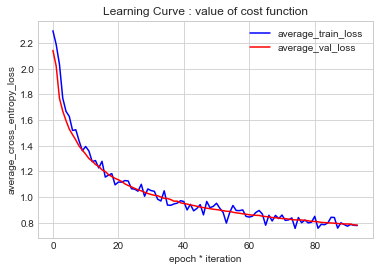

In [46]:
clf.show_learning_curve()

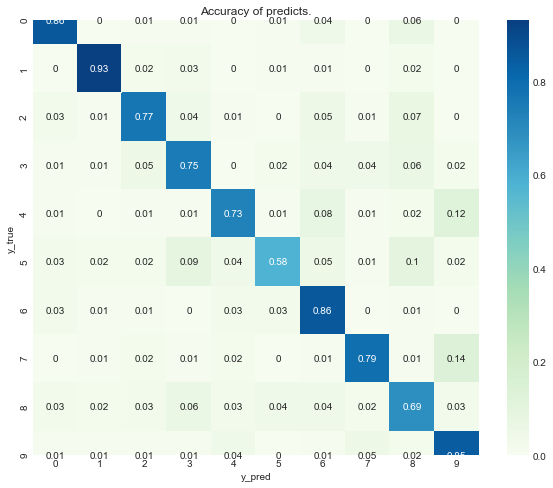

In [47]:
y_pred = clf.predict(X_test)
clf.show_accuracy(y_test)

### 【問題6】（アドバンス課題）LeNet

In [60]:
class LeNet:
    
    def __init__(self, activation="ReLU", batch=30, filter_info=np.array([[6,1,5,5],[16,1,5,5]]), initializer="He", n_epochs=30, lr=1e-2, n_nodes1=120, n_nodes2=84, optimizer="AdaGrad", padding=0,  sigma=0.01, stride=1, verbose=False):
        
        # パラメータ
        self.activation = activation
        self.batch = batch
        self.initializer = initializer
        self.lr = lr
        self.n_epochs = n_epochs
        self.n_features = 6400
        self.n_nodes1 = 120
        self.n_nodes2 = 84
        self.n_output = 10
        self.optimizer = optimizer
        self.sigma = sigma
        self.verbose = verbose
        
        # 畳み込み
        
        # フィルタの特徴量は１次元（FN, FC, FH, FW）のNumpy配列で与える。
        self.F1 = filter_info[0]
        self.F2 = filter_info[1]
        """
        if filter_info.ndim == 1:
            self.F = filter_info[np.newaxis, np.newaxis, np.newaxis, :]
        elif filter_info.ndim == 2:
            self.F = filter_info[np.newaxis, np.newaxis, :, :]
        elif filter_info.ndim == 3:
            self.F = filter_info[np.newaxis, :, :, :]
        """
        
        #print("self.F : {}".format(filter_info.ndim))
        
        self.P = padding
        self.S = stride
        
        # パラメータ初期値
        if self.initializer == "Simple":
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
        elif self.initializer == "Xavier":
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
        elif self.initializer == "He":
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
        
        # 最適化手法
        if self.optimizer == "SGD":
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)
        
        # 活性化関数
        self.activation5 = Softmax()
        if self.activation == "Sigmoid":
            self.activation1 = Sigmoid()
            self.activation2 = Sigmoid()
            self.activation3 = Sigmoid()
            self.activation4 = Sigmoid()
        elif self.activation == "Tanh":
            self.activation1 = Tanh()
            self.activation2 = Tanh()
            self.activation3 = Tanh()
            self.activation4 = Tanh()
        elif self.activation == "ReLU":
            self.activation1 = ReLU()
            self.activation2 = ReLU()
            self.activation3 = ReLU()
            self.activation4 = ReLU()
        
        
        # レイヤー（インスタンス生成）
        self.Conv1 = Conv2d(self.lr, self.F1, self.P, self.S, self.sigma) # 畳み込み（出力チャンネル６）
        self.Conv2 = Conv2d(self.lr, self.F2, self.P, self.S, self.sigma) # 畳み込み（出力チャンネル１６）
        self.Pool1 = MaxPool2D(self.S, self.P) # プーリング層
        self.Pool2 = MaxPool2D(self.S, self.P) # プーリング層
        self.Flat = Flatten() # 平滑化
        self.FC1 = FC(self.n_features, self.n_nodes1, initializer1, optimizer1) # 全結合層
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2) # 全結合層
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3) # 全結合層
        
        # 損失
        self.train_loss = []
        self.val_loss = []
        
        # 予測値
        self.y_pred = None
        
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        
        # 特徴量にチャンネルの次元がない場合、チャンネルの軸を追加する
        if X_train.ndim == 3:
            X_train = X_train[:, np.newaxis, :, :]

        # 入力データのチャンネル数とフィルタのチャンネル数の一致を確認する
        if (X_train.shape[1] != self.F1[1]) or (X_train.shape[1] != self.F2[1]):
            print("Channels of X_train and filter should be same.")
            

        # One-Hot Encoding
        enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
        y_train = enc.fit_transform(y_train[:, np.newaxis]) # 学習用データ
        
        # 検証用データが存在する場合は、同様に前処理する
        if (X_val is not None) and  (y_val is not None):
            y_val = enc.fit_transform(y_val[:, np.newaxis])            
            if X_val.ndim == 3:
                X_val = X_val[:, np.newaxis, :, :]
            if X_val.shape[1] != self.F1[1]:
                print("Channels of X_val and filter should be same.")
                
            
        # 選択した最適化手法による学習を繰り返す
        for i in tqdm(range(self.n_epochs)):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size = self.batch, seed = 0)
            for mini_X_train, mini_y_train in tqdm(get_mini_batch):
                
                # フォワードプロパゲーション
                A1 = self.Conv1.forward(mini_X_train) # Conv 
                Z1 = self.activation1.forward(A1) # ReLU
                Z2 = self.Pool1.forward(Z1) # Pool
                A2 = self.Conv2.forward(Z2) # Conv
                Z3 = self.activation2.forward(A2) # ReLU
                Z4 = self.Pool2.forward(Z3) # Pool
                Z5 = self.Flat.forward(Z4) # Flatten
                A3 = self.FC1.forward(Z5) # Affine
                Z6 = self.activation3.forward(A3) # ReLU
                A4 = self.FC2.forward(Z6) # Affine
                Z7 = self.activation4.forward(A4) # ReLU
                A5 = self.FC3.forward(Z7) # Affine
                Z8 = self.activation5.forward(A5) # SoftMax
                
                
                # バックワードプロパゲーション
                dA5, train_loss = self.activation5.backward(Z8, mini_y_train)
                dZ7 = self.FC3.backward(dA5)
                dA4 = self.activation4.backward(dZ7)
                dZ6 = self.FC2.backward(dA4)
                dA3 = self.activation3.backward(dZ6)
                dZ5 = self.FC1.backward(dA3)
                dZ4 = self.Flat.backward(dZ5)
                dZ3 = self.Pool2.backward(dZ4)
                dA2 = self.activation2.backward(dZ3)
                dZ2 = self.Conv2.backward(dA2)
                dZ1 = self.Pool1.backward(dZ2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Conv1.backward(dA1)
                
                self.train_loss.append(train_loss)
                
                if self.verbose == True:
                    print("train_loss : {}".format(train_loss))
                
            # 検証用データを用いる場合、損失を計算する
            if (X_val is not None) and (y_val is not None):
                get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size = self.batch, seed = 0)
                for mini_X_val, mini_y_val in get_mini_batch_val:
                    A1_val = self.Conv1.forward(mini_X_val) # Conv 
                    Z1_val = self.activation1.forward(A1_val) # ReLU
                    Z2_val = self.Pool1.forward(Z1_val) # Pool
                    A2_val = self.Conv2.forward(Z2_val) # Conv
                    Z3_val = self.activation2.forward(A2_val) # ReLU
                    Z4_val = self.Pool2.forward(Z3_val) # Pool
                    Z5_val = self.Flat.forward(Z4_val) # Flatten
                    A3_val = self.FC1.forward(Z5_val) # Affine
                    Z6_val = self.activation3.forward(A3_val) # ReLU
                    A4_val = self.FC2.forward(Z6_val) # Affine
                    Z7_val = self.activation4.forward(A4_val) # ReLU
                    A5_val = self.FC3.forward(Z7_val) # Affine
                    Z8_val = self.activation5.forward(A5_val) # SoftMax
                    
                    _, val_loss = self.activation5.backward(Z8_val, mini_y_val) # 損失を計算

                    # 損失を格納
                    self.val_loss.append(val_loss)

                # 学習過程を表示
                if self.verbose == True:
                    print("val_loss : {}".format(val_loss))

            
    def predict(self, X):
        
       # 特徴量にチャンネルの次元がない場合、チャンネルの軸を追加する
        if X.ndim == 3:
            X = X[:, np.newaxis, :, :]

        # 入力データのチャンネル数とフィルタのチャンネル数の一致を確認する
        if (X.shape[1] != self.F1[1]) or (X.shape[1] != self.F2[1]):
            print("Channels of X_train and filter should be same.")
        
        # フォワードプロパゲーション
        A1 = self.Conv1.forward(X) # Conv 
        Z1 = self.activation1.forward(A1) # ReLU
        Z2 = self.Pool1.forward(Z1) # Pool
        A2 = self.Conv2.forward(Z2) # Conv
        Z3 = self.activation2.forward(A2) # ReLU
        Z4 = self.Pool2.forward(Z3) # Pool
        Z5 = self.Flat.forward(Z4) # Flatten
        A3 = self.FC1.forward(Z5) # Affine
        Z6 = self.activation3.forward(A3) # ReLU
        A4 = self.FC2.forward(Z6) # Affine
        Z7 = self.activation4.forward(A4) # ReLU
        A5 = self.FC3.forward(Z7) # Affine
        Z8 = self.activation5.forward(A5) # SoftMax
        
        # 確率が最大のインデックスを返す
        y_pred = np.argmax(Z8, axis=1)
        
        self.y_pred = y_pred
        
        return y_pred


    def show_learning_curve(self,):
        
        iteration = np.arange(len(self.train_loss))
        train_loss = self.train_loss
        val_loss = self.val_loss
        
        plt.style.use("seaborn-whitegrid")
        
        # 損失の推移を描画
        plt.plot(iteration, train_loss, label = "average_train_loss", color="b")
        if val_loss is not None:
            plt.plot(iteration, val_loss, label="average_val_loss", color="r")
        plt.xlabel("epoch * iteration")
        plt.ylabel("average_cross_entropy_loss")
        plt.title("Learning Curve : value of cost function")
        plt.legend(loc="best")
        plt.show()

        
    def show_accuracy(self, y):
        
        # カウント
        true_false  = np.zeros(100).reshape(10,10)

        # 正解ラベル、予測値の正誤表を作成
        for i in range(len(y)):
            true = y[i]
            pred = self.y_pred[i]

            true_false[true][pred] += 1

        # パーセンテージ換算
        true_false = np.round(true_false / np.sum(true_false, axis=1), 2)

        # 可視化
        plt.figure(figsize=(10, 8))
        sns.heatmap(true_false, annot=True, cmap="GnBu")
        plt.xlabel("y_pred")
        plt.ylabel("y_true")
        plt.title("Accuracy of predicts.")
        plt.show()        
        


# ミニバッチを生成するクラス

    
class GetMiniBatch:
    
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]



# 以下、全結合層クラス

class FC:
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.initializer = initializer
        self.optimizer = optimizer
        
        self.W = initializer.W(n_nodes1, n_nodes2) # 重みの初期値
        self.B = initializer.B(n_nodes2) # バイアスの初期値
        
        self.forward_Z = None
        self.dB = None
        self.dW = None
    
    
    def forward(self, Z):
        
        self.forward_Z = Z.copy()
        A = np.dot(self.forward_Z, self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        
        self.dB = dA
        
        self.dW = np.dot(self.forward_Z.T, dA)
        
        dZ = np.dot(dA, self.W.T)
        
        # 重み、バイアスを更新
        self = self.optimizer.update(self)
        
        return dZ


# 以下、最適化手法のクラス

class SGD:
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        
        layer.W = layer.W - self.lr * layer.dW/ layer.dB.shape[0]
        
        layer.B = layer.B - self.lr * np.mean(layer.dB, axis=0)
        
        return layer

    
class AdaGrad:
    
    def __init__(self, lr):
        
        self.lr = lr
        
        self.H_W = 0
        self.H_B = 0
        
    def update(self, layer):
        
        dW_mean = layer.dW/ layer.dB.shape[0]
        dB_mean = np.mean(layer.dB, axis = 0)

        self.H_W += dW_mean**2
        layer.W = layer.W - self.lr * np.sqrt(1/ (self.H_W + 1e-10)) * dW_mean
        
        self.H_B = self.H_B + dB_mean**2
        layer.B = layer.B - self.lr * np.sqrt(1/ (self.H_B + 1e-10)) * dB_mean

        
        return layer    


# 活性化関数クラス

class ReLU:
    
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        
        self.forward_A = A
        
        self.Z = np.maximum(A, 0)
        
        return self.Z

    
    def backward(self, dZ):
        
        return dZ * np.where(self.forward_A > 0, 1, 0)
    

class Softmax:
    
    def __init__(self, ):
        
        self.Z3 = None
    
    def forward(self, X):

        c = np.max(X)
        
        # オーバーフロー対策を実施（要素の最大値を各要素から控除）
        self.Z3 = np.exp(X - c) / np.sum(np.exp(X - c), axis=1).reshape(-1,1)
        
        return self.Z3
    
    
    def backward(self, Z3, Y):
        
        dA = Z3 - Y
        
        # 交差エントロピー誤差
        loss = - np.sum(Y * np.log(Z3 + 1e-7)) / Y.shape[0]
        
        
        return dA, loss
    
    
# パラメータ初期化クラス
    
class SimpleInitializer:
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):

        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B



class XavierInitializer:
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        
        self.sigma = np.sqrt(1/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

    
class HeInitializer:
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        
        self.sigma = np.sqrt(2/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B


# CNN関連のクラス
    
class Conv2d:
    
    def __init__(self, lr, F, P, S, sigma):
        
        self.lr = lr
        
        # 入力値
        self.N_in = None # サンプル数
        self.C_in = None # チャンネル数
        self.H_in = None # 高さ
        self.W_in = None # 横幅       
        
        # フィルタ
        self.FN = F[0] # フィルタ数
        self.FC = F[1] # カーネル数
        self.FH = F[2] # カーネルの高さ
        self.FW = F[3] # カーネルの横幅
        self.F = np.random.randn(self.FN, self.FC, self.FH, self.FW)
        
        # バイアス
        #self.B = sigma * np.random.randn(self.FC).reshape(self.FC, 1, 1)
        self.B = sigma * np.random.randn(self.FC, 1, 1)
        
        # パディング
        self.PH = P # 高さ
        self.PW = P # 横幅
                
        # ストライド
        self.SH = S # 高さ
        self.SW = S # 横幅
        
        # 出力値
        self.N_out = None # サンプル数
        self.C_out = None # チャンネル数
        self.H_out = None # 高さ
        self.W_out = None # 横幅
        
        # 微分
        self.dA = None # 後の層からの勾配
        self.dB = None # バイアス
        self.dF = None # フィルタ
        self.dZ = None # 前の層に流す勾配
    
    def forward(self, Z):
                
        self.Z = Z.copy()
        
        # 入力値
        self.N_in = Z.shape[0] # サンプル数
        self.C_in = Z.shape[1] # チャンネル数
        self.H_in = Z.shape[2] # 高さ
        self.W_in = Z.shape[3] # 横幅  
        
        # 出力値
        self.N_out = self.N_in # サンプル数（入力値の数に等しい）
        self.C_out = self.FN # チャネル数（フィルタの枚に等しい）
        
        # パディング
        Z = np.pad(Z, [(0,0),(0,0),(self.PH, self.PH),(self.PW, self.PW)], mode="constant")
        
        # 出力をゼロで初期化（shape：N_in, FN, OH, OW）
        N_out = self.calc_OutputSize()
        
        
        # 畳み込み演算用の配列を生成する（channel, H, W）
        conv = np.zeros((self.FC, self.H_out,  self.W_out))
        
        # 畳み込まれる入力値を格納する配列（N_out, FN, FC, H_out*W_out, FH * FW）
        self.conv_z = np.zeros((self.N_out, self.FN, self.FC, self.H_out*self.W_out, self.FH*self.FW))
        
        # 畳み込み演算を行う
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    count = 0
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            self.conv_z[n_out][fn][fc][count] = Z[n_out][fc][self.SH*h : self.FH + self.SH*h, self.SW*w : self.FW + self.SW*w].flatten()
                            count += 1
                    # フィルタリングした入力値とフィルタのアダマール積を取り、バイアスを加算する
                    adam = self.conv_z[n_out][fn][fc] * self.F[fn][fc].flatten()
                    conv[fc] = np.sum(adam, axis=1).reshape(self.H_out, self.W_out)
                # convをチャネル方向にsumして、置換する
                conv += self.B
                conv_sum = np.sum(conv, axis=0)

                N_out[n_out][fn] = conv_sum

        return N_out
    
    
    def backward(self, dA):
        
        self.dA = dA.copy()
        
        # バイアス
        self.dB = np.sum(dA, axis=(-2,-1))
        
        # 重み
        self.dF = np.zeros((self.FN, self.FC, self.FH, self.FW))
        conv = np.zeros((self.H_out * self.W_out, self.FH * self.FW))
                    
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for i in range(self.H_out*self.W_out):                        
                        conv[i] = dA[n_out][fn].flatten()[i] * self.conv_z[n_out][fn][fc][i]
                    self.dF[fn][fc] = np.sum(conv, axis=0).reshape(self.FH, self.FW)
                    

        # 前の層への勾配
        self.dZ = np.zeros((self.N_in , self.C_in , self.H_in , self.W_in))
        
        # 各カーネルの勾配
        dZ_conv = np.zeros((self.N_in, self.FN * self.FC, self.H_in, self.W_in))
        
        # dAとフィルタのアダマール積をストライド毎に格納する配列
        conv = np.zeros((self.H_out*self.W_out, self.H_in+(self.PH*2), self.W_in+(self.PW*2)))
        
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            conv[h+w][self.SH*h : self.SH*h + self.FH, self.SW * w: self.SW*w + self.FW] = dA[n_out][fn].flatten()[i] * self.F[fn][fc]
                    dZ_conv[n_out][fn+fc] = np.sum(conv, axis=0)
        
        # 最後にチャネル毎に合計する
        for n in range(self.N_in):
            for c in range(self.C_in):
                for i in range(self.FN * self.FC):
                    if i % self.C_in == c:
                        self.dZ[n][c] += dZ_conv[n][i]
                                
        return self.dZ
        
    
    def calc_OutputSize(self, ):
        
        # 出力サイズを計算する
        self.H_out = int(((self.H_in + 2*self.PH - self.FH) / self.SH) + 1) # 高さ
        self.W_out = int(((self.W_in + 2*self.PW - self.FW) / self.SW) + 1) # 幅
        
        # 出力値を初期化する
        N_out = np.zeros((self.N_out, self.C_out , self.H_out, self.W_out)) # 初期化
        
        return N_out
    


class MaxPool2D:
    
    def __init__(self, stride=1, pad=0):
        
        self.stride = stride
        self.pad = pad
        
        self.pool = None
        self.pool_row = None
        self.pool_col = None
        
        self.Z = 0
        self.SH, self.SW = stride, stride
    
    def forward(self, Z):
        
        # 入力値を4次元（N, C, H, W）にする
        if Z.ndim == 1:
            Z = Z[np.newaxis, np.newaxis, np.newaxis, :]
        elif Z.ndim == 2:
            Z = Z[np.newaxis, np.newaxis, :, :]
        elif Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        # 入力値（サンプル、チャンネル、高さ、横幅）
        self.N, self.C, self.H, self.W = Z.shape
        
        # ストライド（高さ、幅）
        SH, SW = self.stride, self.stride
        
        # ストライド数
        self.NH = int(self.H / SH) # 高さ方向に動く回数
        self.NW = int(self.W  / SW) # 横幅方向に動く回数
        
        # プーリング層を初期化
        self.pool = np.zeros((self.N, self.C, self.NH, self.NW))
        self.pool_row = np.zeros((self.N, self.C, self.NH * self.NW))
        self.pool_col = np.zeros((self.N, self.C, self.NH * self.NW))
        
        
        # プーリング
        for n in range(self.N):
            for c in range(self.C):
                count = 0
                for mh in range(self.NH):
                    for mw in range(self.NW):
                        extract = Z[n][c][SH*mh : SH*(mh+1), SW*mw: SW*(mw+1)] # ストライド
                        self.pool[n][c][mh][mw] = np.amax(extract) # ストライドした範囲内で最大値をを見つける
                        index_max = np.unravel_index(np.argmax(extract), extract.shape) # 最大値のインデックスを取得
                        self.pool_row[n][c][count] = index_max[0] + SH*mh
                        self.pool_col[n][c][count] = index_max[1] + SW*mw
                        count += 1
        
        return self.pool
    
    
    def backward(self, dA):
        
        dZ = np.zeros((self.N, self.C, self.H, self.W))
        
        for n in range(self.N):
            for c in range(self.C):
                for i in range(self.NH * self.NW):
                    h = int(self.pool_row[n][c][i] / self.SH)# 勾配を流す要素の行番号
                    w = int(self.pool_col[n][c][i] / self.SW) # 勾配を流す要素の列番号
                    dZ[n][c][h:h+1,w:w+1] = dA[n][c][h:h+1,w:w+1]
        
        return dZ
    

class Flatten:
    
    def __init__(self, ):
        
        self.N = None
        self.C = None
        self.H = None
        self.W = None
        
        self.flat_Z = None
    
    def forward(self, Z):
           
        # 入力値の形状をインスタンス変数に格納
        self.N = Z.shape[0] # サンプル数
        self.C = Z.shape[1] # チャネル数
        self.H = Z.shape[2] # 高さ
        self.W = Z.shape[3] # 横幅
        
        
        # 平滑化する値をゼロで初期化しておく
        self.flat_Z = np.zeros((self.N, self.C*self.H*self.W))
        
        for n in range(self.N):
            self.flat_Z[n] = Z[n].flatten()
        
        return self.flat_Z
    
    
    def backward(self, dA):
        
        dA  = dA.flatten().reshape(self.N, self.C, self.H, self.W)
        
        return dA

**LeNetの検証**

In [61]:
LN = LeNet(batch=48, lr=1e-2, n_epochs=1, verbose=False)

In [62]:
# 学習用データの10%を用いる
n = 4800

In [64]:
LN.fit(X_train[:n], y_train[:n], X_val[:n], y_val[:n])

In [ ]:
LN.show_learning_curve()

In [ ]:
y_pred = LN.predict(X_test[:1000])
LN.show_accuracy(y_test[:1000])

### 【問題7】（アドバンス課題）有名な画像認識モデルの調査

CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがある。

こういったものはフレームワークで既に用意されていることも多い。

どういったものがあるか簡単に調べてまとめること。

- 論文著者であるAlex Krizhevsky氏の名前を冠したモデル。
- ImageNet LSVRC-2010コンテストの120万の高解像度画像を1000の異なるクラスに分類するために、Deep Neural Networkを訓練したもの。
- ネットワークのアーキテクチャ
  - 6,000万個のパラメータと650,000個のニューロンを持つニューラルネットワークは、5つの畳み込み層から構成され、そのうちのいくつかには最大プーリング層が続いている。
  - そして、最後に1000方向のソフトマックスを持つ3つの完全接続層が続く。


- Keras APIでは、ImageNetで事前学習したモデルを利用可能。（VGG16は16層から、VGG19は19層で構成される）
- ImageNetとは何か？
    - WordNet階層に従って整理された画像データセットである。
    - WordNet階層の個々の概念（≒クラス）は、複数の単語または単語の句で記述される。（これらは "synonym set" もしくは "synset"と呼ばれる） 
    - WordNetには100,000以上のsynsetがあり、それらの大部分は名詞である。
    - ImageNetでは、各synsetを説明するために平均1000枚の画像を提供することを目指している。
    - それぞれの概念のイメージは、人の手で注釈が付けられ、品質が管理されている。


- Keras APIでは、ImageNetで事前学習したDenseNetモデルを利用可能。
- ネットワークのアーキテクチャは以下の通り。
   1. Convolution Layer : output_size(112 × 112), 7 × 7 conv, stride2
   2. Pooling Layer : output_size(56 × 56), 3 × 3 max pool, stride2
   3. Dense Layer : output_size(56 × 56), (1×1 conv or 3 × 3 conv) × 6 
   4. Transition Layer : output_size (56 × 56 with "1 × 1conv" or 28 × 28 with "2×2 average pool stride2")
   5. Dense Layer : output_size(28 × 28),  (1×1 conv or 3 × 3 conv) × 12
   6. Transition Layer : output_size (28 × 28 with "1 × 1conv" or 14 × 14 with "2×2 average pool stride2")
   7. Dense Layer : output_size(14 × 14),  (1×1 conv or 3 × 3 conv) × (24 ~ 64)
   8. Transition Layer : output_size (14 × 14 with "1 × 1conv" or 7 × 7 with "2×2 average pool stride2")
   9. Dense Layer : output_size(7 × 7),  (1×1 conv or 3 × 3 conv) × (16 ~ 48)
   10. Classification Layer : output_size(1×1), 7 × 7 global average pool, 1000D fully-connected softmax


- VGG netsに着想を得たモデルで、34の層から構成される（大半が3×3の畳み込み層であり、strideは2）。論文では"Plain Network"と表現されている。
- Plain Networkに、shortcut connectionを追加したResidual Networkも構築されている。
    - shortcut connectionとは、あるconvolutional層の出力を２つ先の畳み込み層の出力に加算するもの。これは畳み込みを行う際に特徴量を補填する（＝残していく）もので、residualの所以となっている。
-  ネットワークのアーキテクチャーは以下の通り。
    - 7 × 7 conv (Layer1) : output_size (112　×　112)
    - Max pooling
    - 3 × 3 conv (Layer2 ~ Layer7) : output_size (56　×　56)
    - 3 × 3 conv (Layer8 ~ Layer15) : output_size (28　×　28)
    - 3 × 3 conv (Layer16 ~ Layer27) : output_size (14　×　14)
    - 3 × 3 conv (Layer28 ~ Layer33) : output_size (7　×　7)
    - global average pooling
    - 1000-way fully-connected Layer with softmax (Layer34)


- Google Inc.が2017年に提唱したモデル。
- Keras APIでは、ImageNetで事前学習したMobileNetモデルを利用可能。
- Depthwise Separable Convolutionを取り入れた点が特徴であり、深さ方向に分離可能な畳み込みに基づいている。
    1. Standard convolution：深さ方向に畳み込む
    2. pointwise convolution：1×1の畳み込み

### 【問題8】（アドバンス課題）平均プーリングの作成

In [54]:
class AveragePool2D:
    
    def __init__(self, F=[2,2], P=[0,0], S=[2,2]):
        
        self.FH, self.FW = F[0], F[1]
        self.P = P
        self.SH, self.SW = S[0], S[1]
        
        self.pool = None
    
    def forward(self, Z):
        
        # 入力値を4次元（N, C, H, W）にする
        if Z.ndim == 1:
            Z = Z[np.newaxis, np.newaxis, np.newaxis, :]
        elif Z.ndim == 2:
            Z = Z[np.newaxis, np.newaxis, :, :]
        elif Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        # 入力値（サンプル、チャンネル、高さ、横幅）
        N, C, H, W = Z.shape
        
        # パディング後の入力値
        X = np.zeros((N, C, H+self.P[0]*2, W+self.P[1]*2))
        
        for n in range(N):
            for c in range(C):
                X[n][c] = np.pad(Z[n][c], pad_width=self.P, mode="constant")
        
        # 入力値の形状を保存
        self.N, self.C, self.H, self.W = X.shape
        
        # ストライド数
        self.NH = int(self.H / self.SH) # 高さ方向に動く回数
        self.NW = int(self.W  / self.SW) # 横幅方向に動く回数
        
        # プーリング層を初期化
        self.pool = np.zeros((self.N, self.C, self.NH, self.NW))
        self.index = np.zeros((self.N, self.C, self.NH))
        
        
        # 平均プーリング
        for n in range(self.N):
            for c in range(self.C):
                for mh in range(self.NH):
                    for mw in range(self.NW):
                        extract = X[n][c][self.FH*mh : self.FH*(mh+1), self.FW*mw: self.FW*(mw+1)] # 畳み込みする範囲を抽出
                        index_ave = np.where(X[n][c][self.FH*mh : self.FH*(mh+1), self.FW*mw: self.FW*(mw+1)]) # 畳み込んだ範囲のインデックスを取得
                        self.pool[n][c][mh][mw] = np.average(extract) # 抽出した範囲内で平均値を算出し、プーリング層の値を置換                      
        
        return self.pool
    
    
    def backward(self, dA):
    
        # 勾配の高さ、幅
        dAH, dAW = dA.shape[2], dA.shape[3]
        
        # 初期化
        dZ = np.zeros((self.N, self.C, self.H, self.W))
        
        for n in range(self.N):
            for c in range(self.C):
                for i in range(dAH):
                    for j in range(dAW):
                        dZ[n][c][i*self.FH : (i+1)*self.FH , j*self.FW : (j+1)*self.FW] = dA[n][c][i][j] * 1/(self.FH*self.FW)
        
        # フォワードプロパゲーション時の入力値と同範囲のみ抽出（＝パディングした範囲に流れた勾配を削除）
        dZ = dZ[: , : , self.P[0] : self.H - self.P[0], self.P[1] : self.W - self.P[1]]
        
        return dZ

**検証**

In [55]:
ave_pool2d = AveragePool2D(P=[2,2], S=[2,2])

In [56]:
sample = np.arange(32).reshape(1,2,4,4)
sample

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]]]])

In [57]:
# forward-propagation
forward = ave_pool2d.forward(sample)
forward, forward.shape

(array([[[[ 0. ,  0. ,  0. ,  0. ],
          [ 0. ,  2.5,  4.5,  0. ],
          [ 0. , 10.5, 12.5,  0. ],
          [ 0. ,  0. ,  0. ,  0. ]],
 
         [[ 0. ,  0. ,  0. ,  0. ],
          [ 0. , 18.5, 20.5,  0. ],
          [ 0. , 26.5, 28.5,  0. ],
          [ 0. ,  0. ,  0. ,  0. ]]]]), (1, 2, 4, 4))

In [58]:
# backward-propagation
gradient = np.arange(forward.size).reshape(forward.shape)
gradient

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]]]])

In [59]:
backward = ave_pool2d.backward(gradient)
backward, backward.shape

(array([[[[1.25, 1.25, 1.5 , 1.5 ],
          [1.25, 1.25, 1.5 , 1.5 ],
          [2.25, 2.25, 2.5 , 2.5 ],
          [2.25, 2.25, 2.5 , 2.5 ]],
 
         [[5.25, 5.25, 5.5 , 5.5 ],
          [5.25, 5.25, 5.5 , 5.5 ],
          [6.25, 6.25, 6.5 , 6.5 ],
          [6.25, 6.25, 6.5 , 6.5 ]]]]), (1, 2, 4, 4))

### 【問題9】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要がある。

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になる。

フレームワークでは各層のパラメータ数を表示させることが可能だが、意味を理解していなくては適切な調整が行えない。

以下の3つの畳み込み層の出力サイズとパラメータ数を計算すること。（パラメータ数についてはバイアス項も考える）

1.

入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし
2.

入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし
3.

入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし
＊最後の例は丁度良く畳み込みをすることができない場合。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算すること。端が欠けてしまうので、こういった設定は好ましくないという例。

計算結果
output_shape = (1, 6, 141, 141) # (samples, channels, height, width)
output_height = (144 + 2*0 - 3) + 1 = 141
output_width = (144 + 2*0 - 3) + 1 = 141
output_shape = (1, 48, 58, 58) # (samples, channels, height, width)
output_height = (60 + 2*0 - 3) + 1 = 58
output_width = (60 + 2*0 - 3) + 1 = 58
output_shape = (1, 20, 9, 9) # (samples, channels, height, width) => 17〜19行目、17,〜19列目の畳み込みで終える計算。
output_height = ((20-1) + 2*0 - 3)/2 + 1 = 9
output_width = ((20-1) + 2*0 - 3)/2 + 1 = 9

### 【問題10】（アドバンス課題）フィルタサイズに関する調査

畳み込み層にはフィルタサイズというハイパーパラメータがあるが、2次元畳み込み層において現在では3×3と1×1の使用が大半である。

以下のそれぞれを調査し、自分なりに考えて説明すること。

7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
高さや幅方向を持たない1×1のフィルタの効果
調査結果
7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由

：以下の通り、小さなフィルタのほうが相対的に計算コストが低く、より複雑な特徴を捕捉することが可能だから。
フィルタサイズが小さい（＝用いる重みの総数が少ない）ため、計算コストが低い。
例：3×3のフィルタ、２層レイヤー（＝18個の重みを用いる）を通して、１枚の画像(224, 224, 1)のサイズを"4"だけ小さくする場合、計算回数は合計1,758,312回となる。
1層目：887,112回 = 222(output_height) 222(output_width) 18(9 (weight component) + **8 (add weighted components) + 1*** (add bias))
2層目：871,200回 = 220(output_height) 220(output_width) 118(9 (weight component) + **8 (add weighted components) + 1*** (add bias))
多くの層を用いるため、複雑な特徴を抽出することが出来る。（非線形性が強い）
層を深くすることは、すなわち、各層ごとに特徴量のスコープを分割して特徴抽出を行うことを意味する。
フィルタサイズが大きい（＝用いる重みの総数が多い）ため、計算コストが高い。
例：5×5のフィルタ、１層レイヤー（＝25個の重みを用いる）を通して、１枚の画像(224, 224, 1)のサイズを"4"だけ小さくする場合、計算回数は合計2,420,000回となる。
1層目：2,420,000 = 220(output_height) 220(output_width) 50(25 (weight component) + **24 (add weighted components) + 1*** (add bias))
層の数を少なくする必要があり、複雑な特徴抽出が難しい。
高さや幅方向を持たない1×1のフィルタの効果
効果：チャンネル方向に畳み込みを行うことにより、次元削減が行われ、畳み込みの計算量を抑えることができる。
高さや幅方向を持たない1×1のフィルタによる畳み込みをと言う。
実際には、チャンネル方向の軸を持つフィルタを用いてチャンネル方向に畳み込みを行う。